In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
print("DONE")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DONE


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

2021-10-11 13:16:42.731412: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-11 13:16:42.731545: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
train_name=os.listdir('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train')
test_name=os.listdir('../input/rsna-miccai-brain-tumor-radiogenomic-classification/test')

In [4]:
labels=pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
labels

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [5]:
sample=pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
sample

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
...,...,...
82,826,0.5
83,829,0.5
84,833,0.5
85,997,0.5


In [6]:
def load_dicom(path):
    dicom=pydicom.read_file(path)
    data=dicom.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)
    return data

In [7]:
path0='../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1wCE/Image-1.dcm'
img1=load_dicom(path0)
img2=cv2.resize(img1,(9,9)) 
print(img1.shape)
print(img2.shape)

(512, 512)
(9, 9)


In [8]:
train_dir='../input/rsna-miccai-brain-tumor-radiogenomic-classification/train'
trainset=[]
trainlabel=[]
trainidt=[]
for i in tqdm(range(len(labels))):
    idt=labels.loc[i,'BraTS21ID']
    idt2=('00000'+str(idt))[-5:]
    path=os.path.join(train_dir,idt2,'T1wCE')              
    for im in os.listdir(path):
        img=load_dicom(os.path.join(path,im))
        img=cv2.resize(img,(9,9)) 
        image=img_to_array(img)
        image=image/255.0
        trainset+=[image]
        trainlabel+=[labels.loc[i,'MGMT_value']]
        trainidt+=[idt]

  0%|          | 0/585 [00:00<?, ?it/s]

In [9]:
test_dir='../input/rsna-miccai-brain-tumor-radiogenomic-classification/test'
testset=[]
testidt=[]
for i in tqdm(range(len(sample))):
    idt=sample.loc[i,'BraTS21ID']
    idt2=('00000'+str(idt))[-5:]
    path=os.path.join(test_dir,idt2,'T1wCE')               
    for im in os.listdir(path):   
        img=load_dicom(os.path.join(path,im))
        img=cv2.resize(img,(9,9)) 
        image=img_to_array(img)
        image=image/255.0
        testset+=[image]
        testidt+=[idt]
print("Done")

  0%|          | 0/87 [00:00<?, ?it/s]

Done


In [10]:
from tensorflow.keras.utils import to_categorical
y0=np.array(trainlabel)
Y_train=to_categorical(y0)
X_train=np.array(trainset)
X_test=np.array(testset)

In [11]:
model = Sequential()
model.add(Conv2D(64,(4,4),input_shape = (9,9,1),activation = 'relu'))
model.add(Conv2D(32,(2,2),activation = 'relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

2021-10-11 13:31:50.335314: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-11 13:31:50.355434: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-11 13:31:50.355491: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-11 13:31:50.355546: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b0382bc9af97): /proc/driver/nvidia/version does not exist
2021-10-11 13:31:50.357454: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 6, 64)          1088      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          8224      
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [13]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
his = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=1)

2021-10-11 13:31:50.650596: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25081488 exceeds 10% of free system memory.
2021-10-11 13:31:50.754333: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-11 13:31:50.767483: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/100
1210/1210 [==============================] - 8s 6ms/step - loss: 0.6859 - accuracy: 0.5495 - val_loss: 0.6951 - val_accuracy: 0.4921
Epoch 2/100
1210/1210 [==============================] - 7s 6ms/step - loss: 0.6790 - accuracy: 0.5685 - val_loss: 0.6996 - val_accuracy: 0.5197
Epoch 3/100
1210/1210 [==============================] - 7s 6ms/step - loss: 0.6717 - accuracy: 0.5793 - val_loss: 0.7316 - val_accuracy: 0.5257
Epoch 4/100
1210/1210 [==============================] - 7s 6ms/step - loss: 0.6600 - accuracy: 0.5931 - val_loss: 0.7493 - val_accuracy: 0.5293
Epoch 5/100
1210/1210 [==============================] - 7s 5ms/step - loss: 0.6480 - accuracy: 0.6088 - val_loss: 0.7495 - val_accuracy: 0.5117
Epoch 6/100
1210/1210 [==============================] - 7s 6ms/step - loss: 0.6334 - accuracy: 0.6226 - val_loss: 0.7501 - val_accuracy: 0.5190
Epoch 7/100
1210/1210 [==============================] - 9s 8ms/step - loss: 0.6184 - accuracy: 0.6334 - val_loss: 0.7617 - val_ac

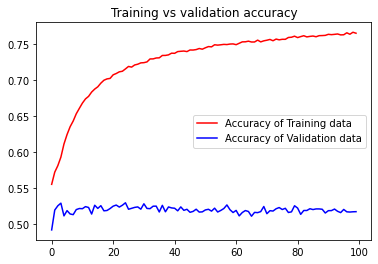

<Figure size 432x288 with 0 Axes>

In [15]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

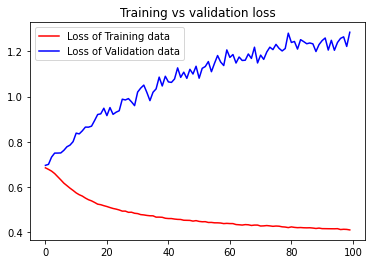

<Figure size 432x288 with 0 Axes>

In [16]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [17]:
y_pred=model.predict(X_test)
pred=np.argmax(y_pred,axis=1)
result=pd.DataFrame(testidt)
result[1]=pred
result.columns=['BraTS21ID','MGMT_value']
result2=result.groupby('BraTS21ID',as_index=False).mean()
result2

,BraTS21ID,MGMT_value
0,1,0.852713
1,13,0.674419
2,15,0.792763
3,27,0.759868
4,37,0.806202
...,...,...
82,826,0.562500
83,829,0.481481
84,833,0.468750
85,997,0.583333


In [18]:
result2['BraTS21ID']=sample['BraTS21ID']
result2['MGMT_value']=result2['MGMT_value'].apply(lambda x:round(x*10)/10)
result2.to_csv('submission.csv',index=False)
result2

,BraTS21ID,MGMT_value
0,1,0.9
1,13,0.7
2,15,0.8
3,27,0.8
4,37,0.8
...,...,...
82,826,0.6
83,829,0.5
84,833,0.5
85,997,0.6
